In [4]:
import pandas as pd 
df = pd.read_csv('sorted_data_2.csv')
df_5 = pd.read_csv('merged_nfhs5_district_level.csv')


--- DEBUG: Columns in Merged Data ---
['state_x', 'district', 'internet_5', 'mobile_5', 'gender_5', 'internet_use_m_5', 'mobile_own_m_5', 'internet_use_f_5', 'mobile_own_f_5', 'dd_internet_use_5', 'dd_mobile_own_5', 'State_Code', 'DistrictCode', 'in_labour_force', 'Employed', 'Unemployed', 'Employed_self', 'Employed_ownacc', 'Employed_ownent', 'Employed_help', 'Employed_Salaried', 'Employed_wages', 'Employed_casual', 'men_mobile_own_4', 'men_mobile_financial_4', 'men_mobile_own2_4', 'men_mobile_financial2_4', 'n_obs_men_4', 'women_mobile_own_4', 'n_obs_women_4', 'digital_gap_ownership_4', 'male_mean_age', 'male_mean_education', 'male_pct_no_education', 'male_pct_primary_education', 'male_pct_secondary_education', 'male_pct_higher_education', 'male_literacy_rate', 'male_urban_share', 'male_pct_sc', 'male_pct_st', 'male_pct_obc', 'male_pct_general', 'male_pct_hindu', 'male_pct_muslim', 'male_pct_christian', 'male_pct_other_religion', 'male_mean_wealth_index', 'male_pct_wealth_q1', 'male

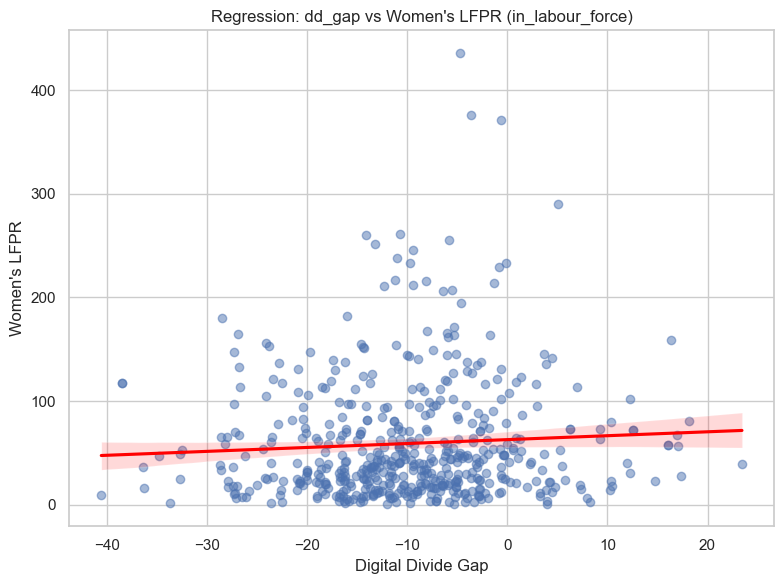


--- Analysis 2: Correlation (Breastfeeding) ---


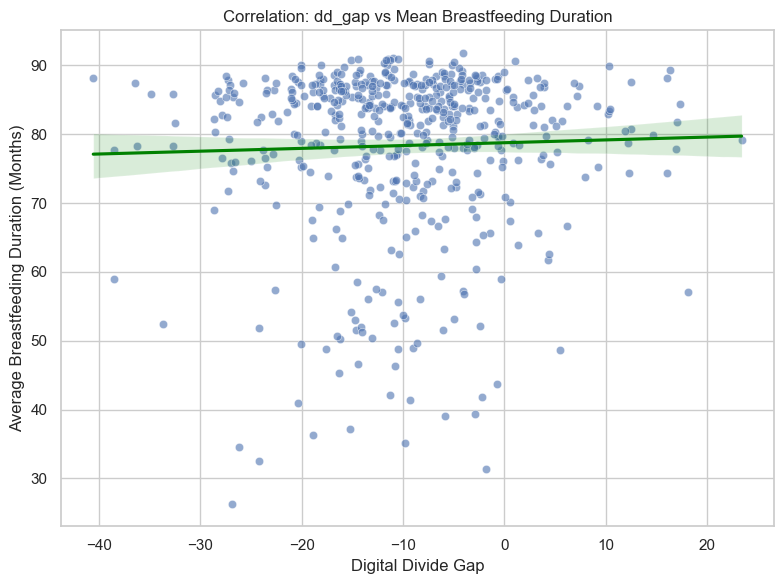


--- Analysis 3: Correlation (Domestic Violence) ---


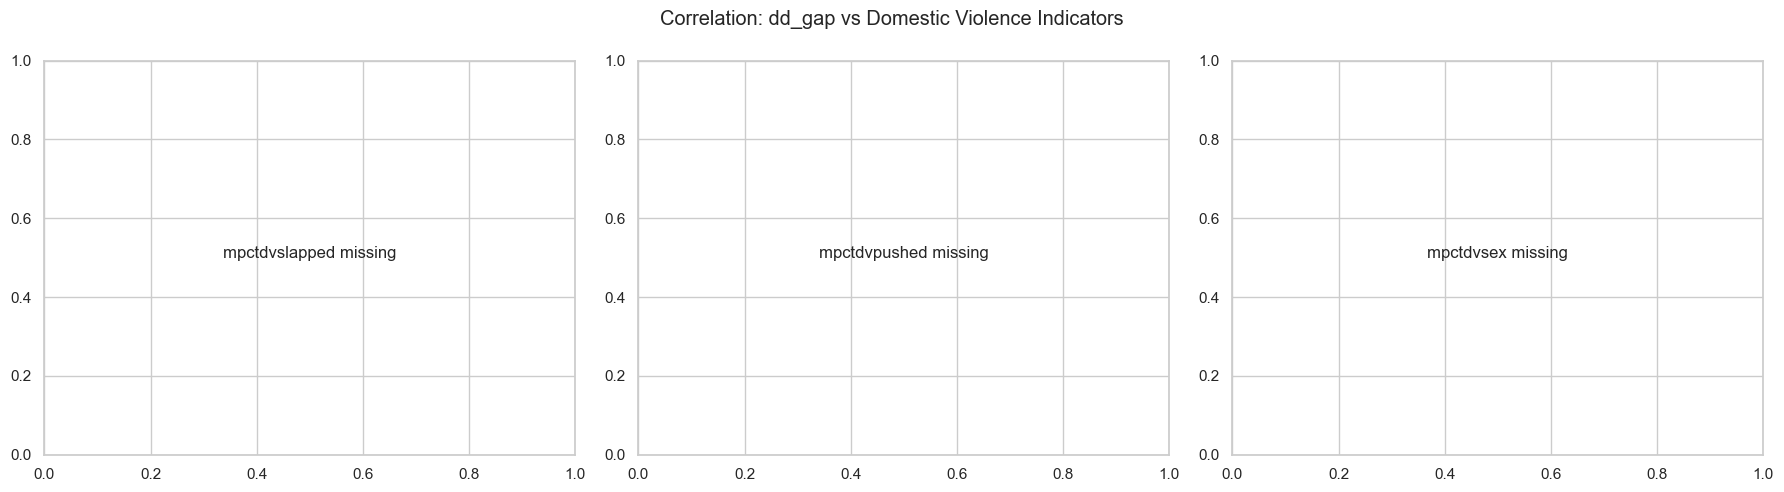


--- Analysis 4: Correlation (Employment) ---


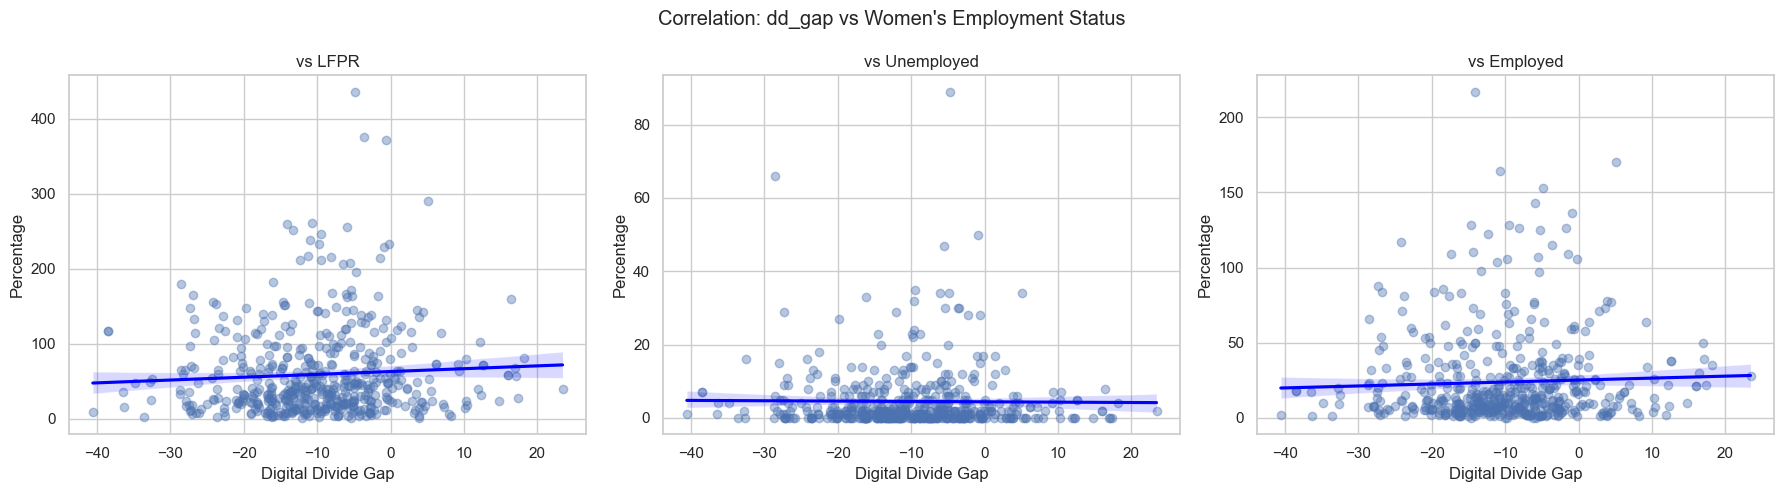

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ---------------------------------------------------------
# 1. Configuration & Variable Mapping
# ---------------------------------------------------------
# Update these strings to match the exact column headers in your CSV files
config = {
    'x_axis_var': 'dd_gap',  # The digital divide/gap column
    
    # Dependent Variables (Y-axis) - UPDATED BASED ON IMAGE
    'lfpr': 'in_labour_force',      # Inferred from 'in_labour_...'
    'unemployed': 'Unemployed',     # Inferred from 'Unemploy...'
    'employed_gen': 'Employed',     # Visible in image
    
    'domestic_violence': ['mpctdvslapped', 'mpctdvpushed', 'mpctdvsex'],
    'breastfeeding': [
        'f_mean_bf_dur_c1', 'f_mean_bf_dur_c2', 'f_mean_bf_dur_c3', 
        'f_mean_bf_dur_c4', 'f_mean_bf_dur_c5', 'f_mean_bf_dur_c6'
    ],
    
    # Control Variables for Regression
    'controls': ['f_mean_age', 'f_pct_married', 'f_pct_ever_breastfed_c1'] 
}

# ---------------------------------------------------------
# 2. Data Preparation & Merging
# ---------------------------------------------------------

# Load your datasets (Replace these with your actual file paths)
# df = pd.read_csv('path_to_digital_gap_data.csv')
# df_5 = pd.read_csv('path_to_nfhs5_data.csv')

# Ensure the X-axis variable exists in the main dataframe
if config['x_axis_var'] not in df.columns:
    print(f"Warning: '{config['x_axis_var']}' not found in df. Please check column names.")

# Merge datasets on 'district'
merged_df = pd.merge(df, df_5, on='district', how='inner')

# DEBUG: Print columns to help user find typos
print("\n--- DEBUG: Columns in Merged Data ---")
print(merged_df.columns.tolist())
print("-------------------------------------\n")

# Identify columns to clean
target_cols = [config['x_axis_var'], config['lfpr']] + config['controls']

# Check for missing columns before dropping NAs
missing_cols = [col for col in target_cols if col not in merged_df.columns]
if missing_cols:
    print(f"CRITICAL WARNING: The following columns are missing from the merged data: {missing_cols}")
    print("The script will attempt to run without them, but analysis may fail.")
    # Remove missing columns from our check list to prevent KeyError
    target_cols = [col for col in target_cols if col in merged_df.columns]

# Drop rows with missing values only for columns that actually exist
if target_cols:
    merged_df.dropna(subset=target_cols, inplace=True)

# Set global visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ---------------------------------------------------------
# Analysis 1: Regression (Digital Gap vs. Women's LFPR)
# Controls: Age, Marital Status, Breastfeeding Proxy
# ---------------------------------------------------------

print("--- Analysis 1: Regression (LFPR) ---")

if config['lfpr'] in merged_df.columns and config['x_axis_var'] in merged_df.columns:
    # Filter controls to only use ones that exist
    active_controls = [c for c in config['controls'] if c in merged_df.columns]
    
    if active_controls:
        controls_str = " + ".join(active_controls)
        formula = f"{config['lfpr']} ~ {config['x_axis_var']} + {controls_str}"
    else:
        print("Warning: No control variables found. Running simple regression.")
        formula = f"{config['lfpr']} ~ {config['x_axis_var']}"

    try:
        model = smf.ols(formula=formula, data=merged_df).fit()
        print(model.summary())

        # Visualization
        plt.figure(figsize=(8, 6))
        sns.regplot(x=config['x_axis_var'], y=config['lfpr'], data=merged_df, 
                    scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.title(f"Regression: {config['x_axis_var']} vs Women's LFPR ({config['lfpr']})")
        plt.xlabel("Digital Divide Gap")
        plt.ylabel("Women's LFPR")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not run regression. Error: {e}")
else:
    print(f"Skipping Analysis 1: '{config['lfpr']}' column missing.")


# ---------------------------------------------------------
# Analysis 2: Correlation (Gap vs. Breastfeeding)
# Y-axis: Mean breastfeeding duration
# ---------------------------------------------------------

print("\n--- Analysis 2: Correlation (Breastfeeding) ---")

# Check which columns actually exist in the dataframe
existing_bf_cols = [col for col in config['breastfeeding'] if col in merged_df.columns]

if existing_bf_cols and config['x_axis_var'] in merged_df.columns:
    # Calculate average across the breastfeeding columns
    merged_df['mean_bf_duration_avg'] = merged_df[existing_bf_cols].mean(axis=1)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=config['x_axis_var'], y='mean_bf_duration_avg', data=merged_df, alpha=0.6)
    sns.regplot(x=config['x_axis_var'], y='mean_bf_duration_avg', data=merged_df, scatter=False, color='green')
    
    plt.title(f"Correlation: {config['x_axis_var']} vs Mean Breastfeeding Duration")
    plt.xlabel("Digital Divide Gap")
    plt.ylabel("Average Breastfeeding Duration (Months)")
    plt.tight_layout()
    plt.show()
else:
    print("Breastfeeding columns or X-axis variable not found.")


# ---------------------------------------------------------
# Analysis 3: Correlation (Gap vs. Domestic Violence)
# Variables: Slapping, Pushing, Sexual Violence
# ---------------------------------------------------------

print("\n--- Analysis 3: Correlation (Domestic Violence) ---")

dv_titles = ['Slapping', 'Pushing', 'Sexual Violence']

# Create a subplot grid (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for ax, var, title in zip(axes, config['domestic_violence'], dv_titles):
    if var in merged_df.columns and config['x_axis_var'] in merged_df.columns:
        sns.regplot(x=config['x_axis_var'], y=var, data=merged_df, ax=ax, 
                    scatter_kws={'alpha':0.4}, line_kws={'color':'darkred'})
        ax.set_title(f"vs {title}")
        ax.set_xlabel("Digital Divide Gap")
        ax.set_ylabel("Prevalence (%)")
    else:
        ax.text(0.5, 0.5, f"{var} missing", ha='center')

plt.suptitle(f"Correlation: {config['x_axis_var']} vs Domestic Violence Indicators")
plt.tight_layout()
plt.show()


# ---------------------------------------------------------
# Analysis 4: Correlation (Gap vs. Women's Employment)
# Variables: Self-employed, Employed, Unemployed
# ---------------------------------------------------------

print("\n--- Analysis 4: Correlation (Employment) ---")

emp_vars = [config['lfpr'], config['unemployed'], config['employed_gen']]
emp_titles = ['LFPR', 'Unemployed', 'Employed']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, var, title in zip(axes, emp_vars, emp_titles):
    if var in merged_df.columns and config['x_axis_var'] in merged_df.columns:
        sns.regplot(x=config['x_axis_var'], y=var, data=merged_df, ax=ax, 
                    scatter_kws={'alpha':0.4}, line_kws={'color':'blue'})
        ax.set_title(f"vs {title}")
        ax.set_xlabel("Digital Divide Gap")
        ax.set_ylabel("Percentage")
    else:
        ax.text(0.5, 0.5, f"{var} missing", ha='center')

plt.suptitle(f"Correlation: {config['x_axis_var']} vs Women's Employment Status")
plt.tight_layout()
plt.show()

Column 'is_treated' not found. Creating proxy based on Digital Gap median.

--- Generating Boxplots ---


C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_21936\469907915.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=var, data=merged_df, ax=axes[idx], palette=palette)
C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_21936\469907915.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=var, data=merged_df, ax=axes[idx], palette=palette)
C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_21936\469907915.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=var, data=merged_df, ax=axes[idx], 

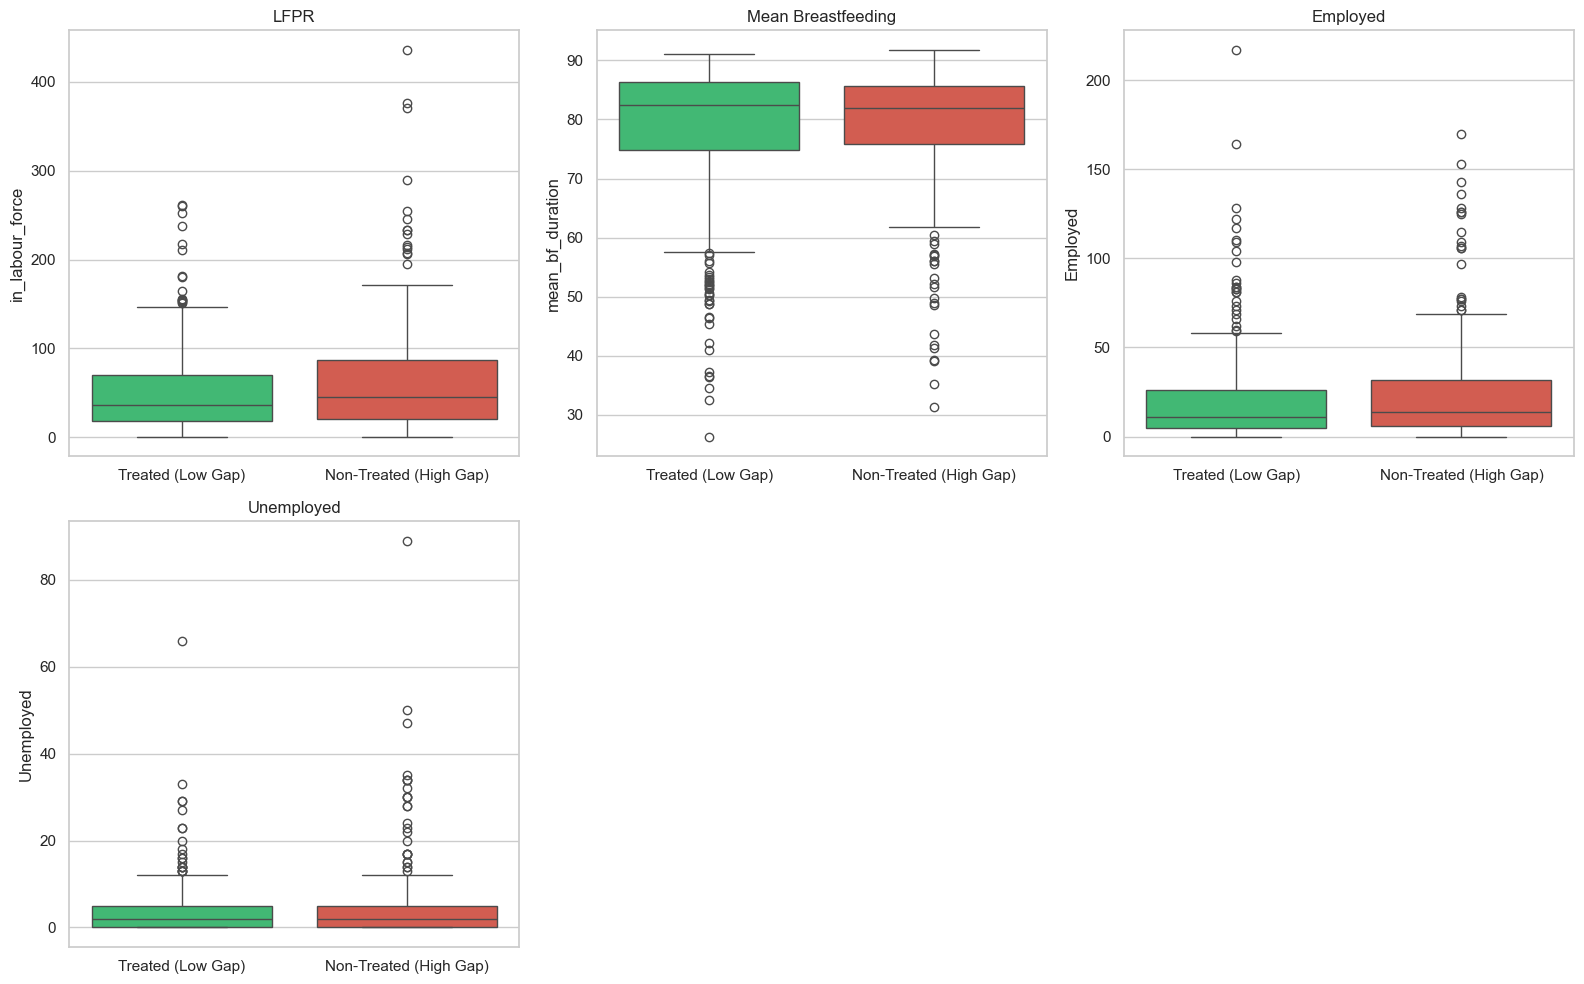


--- Difference in Means Analysis ---
Comparing Group A: Treated (Low Gap) vs Group B: Non-Treated (High Gap)
         Outcome  Mean (Treated (Low Gap))  Mean (Non-Treated (High Gap))  Difference  P-Value Sig (p<0.05)
 in_labour_force                     53.35                          64.01      -10.66   0.0342            ✓
mean_bf_duration                     77.63                          79.00       -1.37   0.1506            ✗
        Employed                     22.43                          24.72       -2.29   0.3704            ✗
      Unemployed                      4.00                           4.90       -0.91   0.2000            ✗

--- Generating Scatterplots with Regression Lines ---


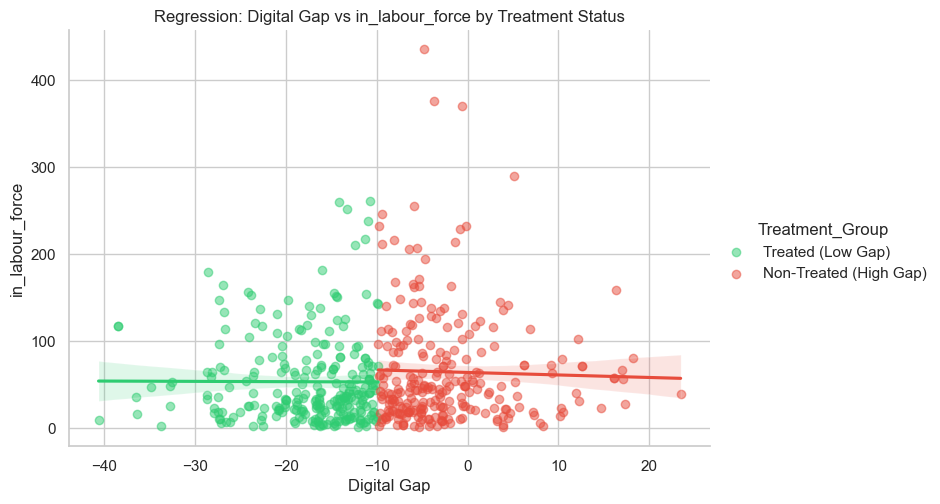

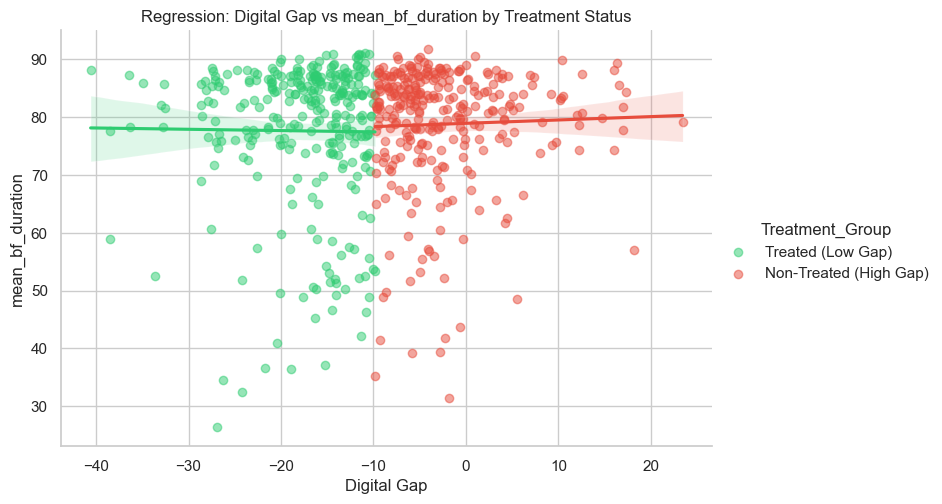


--- Sample Size & Descriptive Statistics ---
                       in_labour_force                      mean_bf_duration  \
                                 count      mean        std            count   
Treatment_Group                                                                
Non-Treated (High Gap)             271  64.00738  64.801863              310   
Treated (Low Gap)                  260  53.35000  50.206644              295   

                                              
                             mean        std  
Treatment_Group                               
Non-Treated (High Gap)  79.001929  10.404378  
Treated (Low Gap)       77.633317  12.793267  

--- Map Visualization ---
Geopandas library not installed. Skipping map.


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# ---------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------
config = {
    'x_axis_var': 'dd_gap',  # Used for scatterplots and defining treatment if missing
    
    # Set this to your actual treatment column name if you have one (e.g., 'intervention_group')
    # If this column is NOT found, the script will create a proxy based on the median of dd_gap.
    'treatment_col': 'is_treated', 
    
    # Y-axis Variables
    'lfpr': 'in_labour_force',
    'employment_status': ['Employed', 'Unemployed'], # Assuming 'Employed' implies self-employed/employed split isn't separate cols unless specified
    'domestic_violence': ['mpctdvslapped', 'mpctdvpushed', 'mpctdvsex'],
    'breastfeeding': [
        'f_mean_bf_dur_c1', 'f_mean_bf_dur_c2', 'f_mean_bf_dur_c3', 
        'f_mean_bf_dur_c4', 'f_mean_bf_dur_c5', 'f_mean_bf_dur_c6'
    ]
}

# ---------------------------------------------------------
# 2. Data Loading & Preparation
# ---------------------------------------------------------
# df = pd.read_csv('path_to_digital_gap.csv')
# df_5 = pd.read_csv('path_to_nfhs5.csv')

# Merge
merged_df = pd.merge(df, df_5, on='district', how='inner')

# --- TREATMENT DEFINITION LOGIC ---
if config['treatment_col'] in merged_df.columns:
    print(f"Using existing column '{config['treatment_col']}' for treatment groups.")
else:
    print(f"Column '{config['treatment_col']}' not found. Creating proxy based on Digital Gap median.")
    median_gap = merged_df[config['x_axis_var']].median()
    # Example Logic: Low Gap = Treated (Better outcome assumptions), High Gap = Non-Treated
    # Adjust logic as per your specific study design
    merged_df['Treatment_Group'] = np.where(
        merged_df[config['x_axis_var']] < median_gap, 'Treated (Low Gap)', 'Non-Treated (High Gap)'
    )

# Calculate Breastfeeding Mean (Aggregating c1-c6)
bf_cols = [c for c in config['breastfeeding'] if c in merged_df.columns]
if bf_cols:
    merged_df['mean_bf_duration'] = merged_df[bf_cols].mean(axis=1)

# Global Plot Settings
sns.set_theme(style="whitegrid")
colors = {"Treated (Low Gap)": "#2ecc71", "Non-Treated (High Gap)": "#e74c3c"}
# Map custom colors if using proxy, otherwise let seaborn pick default
palette = colors if 'Treatment_Group' in merged_df.columns else "Set1"
group_col = 'Treatment_Group' if 'Treatment_Group' in merged_df.columns else config['treatment_col']

# ---------------------------------------------------------
# 3. Boxplots / Bar Charts
# ---------------------------------------------------------
print("\n--- Generating Boxplots ---")

outcomes_to_plot = {
    'LFPR': config['lfpr'],
    'Mean Breastfeeding': 'mean_bf_duration'
}
# Add DV columns
for dv in config['domestic_violence']:
    if dv in merged_df.columns:
        outcomes_to_plot[dv] = dv
# Add Employment columns
for emp in config['employment_status']:
    if emp in merged_df.columns:
        outcomes_to_plot[emp] = emp

# Generate a grid of boxplots
num_vars = len([v for v in outcomes_to_plot.values() if v in merged_df.columns])
if num_vars > 0:
    cols = 3
    rows = (num_vars // cols) + (1 if num_vars % cols > 0 else 0)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
    axes = axes.flatten()
    
    idx = 0
    for title, var in outcomes_to_plot.items():
        if var in merged_df.columns:
            sns.boxplot(x=group_col, y=var, data=merged_df, ax=axes[idx], palette=palette)
            axes[idx].set_title(title)
            axes[idx].set_xlabel("")
            idx += 1
            
    # Hide empty subplots
    for i in range(idx, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 4. Difference-in-Means Tables
# ---------------------------------------------------------
print("\n--- Difference in Means Analysis ---")

results = []
groups = merged_df[group_col].unique()

# Ensure we have exactly 2 groups for T-Test; otherwise, skip
if len(groups) == 2:
    group_a = groups[0]
    group_b = groups[1]
    
    print(f"Comparing Group A: {group_a} vs Group B: {group_b}")

    # Analyze all numeric outcomes
    all_outcomes = [config['lfpr'], 'mean_bf_duration'] + config['domestic_violence'] + config['employment_status']
    
    for var in all_outcomes:
        if var in merged_df.columns:
            data_a = merged_df[merged_df[group_col] == group_a][var].dropna()
            data_b = merged_df[merged_df[group_col] == group_b][var].dropna()
            
            if len(data_a) > 0 and len(data_b) > 0:
                mean_a = data_a.mean()
                mean_b = data_b.mean()
                diff = mean_a - mean_b
                
                # T-Test
                t_stat, p_val = stats.ttest_ind(data_a, data_b, equal_var=False)
                
                # Significance Indicator
                sig = "✓" if p_val < 0.05 else "✗"
                
                results.append({
                    'Outcome': var,
                    f'Mean ({group_a})': round(mean_a, 2),
                    f'Mean ({group_b})': round(mean_b, 2),
                    'Difference': round(diff, 2),
                    'P-Value': round(p_val, 4),
                    'Sig (p<0.05)': sig
                })

    stats_df = pd.DataFrame(results)
    print(stats_df.to_string(index=False))
else:
    print(f"Error: Found {len(groups)} groups. T-test requires exactly 2 groups.")

# ---------------------------------------------------------
# 5. Scatterplots with Regression Lines (by Group)
# ---------------------------------------------------------
print("\n--- Generating Scatterplots with Regression Lines ---")

# Select a few key variables for scatter plots to avoid clutter
key_scatter_vars = [config['lfpr'], 'mean_bf_duration'] + config['domestic_violence'][:1] # Taking first DV var

for var in key_scatter_vars:
    if var in merged_df.columns:
        # lmplot handles the regression lines per group automatically
        g = sns.lmplot(
            data=merged_df, 
            x=config['x_axis_var'], 
            y=var, 
            hue=group_col, 
            palette=palette,
            height=5, 
            aspect=1.5,
            scatter_kws={'alpha': 0.5}
        )
        g.set_axis_labels("Digital Gap", var)
        plt.title(f"Regression: Digital Gap vs {var} by Treatment Status")
        plt.show()

# ---------------------------------------------------------
# 6. Sample Size / Descriptive Table
# ---------------------------------------------------------
print("\n--- Sample Size & Descriptive Statistics ---")

# Group by treatment and count/mean
summary_table = merged_df.groupby(group_col)[[config['lfpr'], 'mean_bf_duration']].agg(['count', 'mean', 'std'])
print(summary_table)

# ---------------------------------------------------------
# 7. (Optional) Choropleth Map Placeholder
# ---------------------------------------------------------
print("\n--- Map Visualization ---")
try:
    import geopandas as gpd
    
    # This section requires a shapefile (.shp) of India Districts
    # shapefile_path = "path/to/india_districts.shp"
    # map_df = gpd.read_file(shapefile_path)
    
    # map_merged = map_df.merge(merged_df, left_on='district_name_in_shp', right_on='district')
    
    # map_merged.plot(column=group_col, categorical=True, legend=True, figsize=(10, 10), cmap='Set2')
    # plt.title("Districts by Treatment Status")
    # plt.show()
    print("Map code included but commented out. Requires 'geopandas' and a .shp file.")
except ImportError:
    print("Geopandas library not installed. Skipping map.")